In [ ]:
!wget https://people.idsia.ch/~luca/macs-vrptw/problems/r101.txt

--2025-05-27 18:54:36--  https://people.idsia.ch/~luca/macs-vrptw/problems/r101.txt
Resolving people.idsia.ch (people.idsia.ch)... 195.176.78.75
Connecting to people.idsia.ch (people.idsia.ch)|195.176.78.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7321 (7.1K) [text/plain]
Saving to: ‘r101.txt’

r101.txt            100%[===================>]   7.15K  --.-KB/s    in 0s      

2025-05-27 18:54:37 (119 MB/s) - ‘r101.txt’ saved [7321/7321]



In [ ]:
# rl_vrp_column_gen.py

"""
RL-Guided Column Generation for VRP (Vehicle Routing Problem)
Runs in Google Colab using benchmark dataset.
"""

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from typing import List

# Define Policy Network
class PolicyNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        return self.fc2(out)

# Define VRP Environment
class VRPEnvRL:
    def __init__(self, demands, dist_matrix, capacity):
        self.demands = demands
        self.dist_matrix = dist_matrix
        self.capacity = capacity
        self.n = len(demands)

    def reset(self):
        self.visited = [False] * self.n
        self.route = [0]
        self.remaining_capacity = self.capacity
        self.total_cost = 0.0
        self.visited[0] = True
        return self._get_state()

    def _get_state(self):
        current = self.route[-1]
        visited = [1.0 if v else 0.0 for v in self.visited]
        return torch.tensor([current, self.remaining_capacity] + visited, dtype=torch.float32)

    def get_masked_actions(self):
        return [i for i in range(1, self.n) if not self.visited[i] and self.demands[i] <= self.remaining_capacity]

    def step(self, action):
        last = self.route[-1]
        self.total_cost += self.dist_matrix[last][action]
        self.remaining_capacity -= self.demands[action]
        self.route.append(action)
        self.visited[action] = True
        return self._get_state()

    def finish(self):
        self.total_cost += self.dist_matrix[self.route[-1]][0]
        self.route.append(0)

    def reward(self, duals):
        return sum(duals[i] for i in self.route if i != 0) - self.total_cost

# Train RL policy

def train_rl_pricing(env, duals, num_episodes=100, hidden_size=32, lr=1e-2):
    input_size = 2 + len(env.demands)
    output_size = len(env.demands)
    policy = PolicyNet(input_size, hidden_size, output_size)
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    for episode in range(num_episodes):
        log_probs = []
        state = env.reset()
        while True:
            logits = policy(state)
            mask = torch.tensor([1.0 if i in env.get_masked_actions() else 0.0 for i in range(len(env.demands))])
            probs = torch.softmax(logits * mask, dim=0)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
            log_probs.append(dist.log_prob(action))
            if action.item() not in env.get_masked_actions():
                break
            state = env.step(action.item())
            if not env.get_masked_actions():
                break
        env.finish()
        R = env.reward(duals)
        loss = -torch.stack(log_probs).sum() * R
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return policy

# Generate batch of columns

def generate_batch_columns(env, policy, duals, batch_size=3):
    columns = []
    rewards = []
    for _ in range(batch_size):
        state = env.reset()
        while True:
            with torch.no_grad():
                logits = policy(state)
                mask = torch.tensor([1.0 if i in env.get_masked_actions() else 0.0 for i in range(len(env.demands))])
                probs = torch.softmax(logits * mask, dim=0)
                dist = torch.distributions.Categorical(probs)
                action = dist.sample()
                if action.item() not in env.get_masked_actions():
                    break
                state = env.step(action.item())
                if not env.get_masked_actions():
                    break
        env.finish()
        columns.append(list(env.route))
        rewards.append(env.reward(duals))
    return columns, rewards

# Load benchmark dataset and run

def run_example():
    # Synthetic or benchmark data (replace with actual benchmark load)
    coords = np.random.rand(7, 2) * 100
    demands = [0, 4, 6, 5, 3, 7, 4]
    vehicle_capacity = 15
    dist_matrix = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=-1)
    duals = [0, 5, 6, 4, 3, 7, 5]  # dummy dual prices

    env = VRPEnvRL(demands, dist_matrix, vehicle_capacity)
    policy = train_rl_pricing(env, duals)
    routes, costs = generate_batch_columns(env, policy, duals)

    df = pd.DataFrame({"Route": routes, "Reduced Cost": costs})
    print("Generated Columns from RL Pricing:")
    print(df)

if __name__ == '__main__':
    run_example()

Generated Columns from RL Pricing:
             Route  Reduced Cost
0  [0, 6, 5, 4, 0]   -151.238202
1  [0, 6, 5, 4, 0]   -151.238202
2     [0, 6, 5, 0]   -147.131338


In [ ]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 85.9 MB/s eta 0:00:00


In [ ]:
# rl_vrp_column_gen.py (Solomon R101 Full Integration)

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import pulp

# === Parser for Solomon Benchmark === #
def parse_solomon(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    capacity = int(lines[4].split()[1])
    data_lines = lines[9:]  # skip header
    coords, demands = [], []
    for line in data_lines:
        parts = line.split()
        if len(parts) >= 5:
            x, y = float(parts[1]), float(parts[2])
            d = int(parts[3])
            coords.append((x, y))
            demands.append(d)
    return np.array(coords), demands, capacity

# === Environment and RL Agent === #
class PolicyNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

class VRPEnvRL:
    def __init__(self, demands, dist_matrix, capacity):
        self.demands = demands
        self.dist_matrix = dist_matrix
        self.capacity = capacity
        self.n = len(demands)
    def reset(self):
        self.visited = [False] * self.n
        self.route = [0]
        self.remaining_capacity = self.capacity
        self.total_cost = 0.0
        self.visited[0] = True
        return self._get_state()
    def _get_state(self):
        current = self.route[-1]
        visited = [1.0 if v else 0.0 for v in self.visited]
        return torch.tensor([current, self.remaining_capacity] + visited, dtype=torch.float32)
    def get_masked_actions(self):
        return [i for i in range(1, self.n) if not self.visited[i] and self.demands[i] <= self.remaining_capacity]
    def step(self, action):
        last = self.route[-1]
        self.total_cost += self.dist_matrix[last][action]
        self.remaining_capacity -= self.demands[action]
        self.route.append(action)
        self.visited[action] = True
        return self._get_state()
    def finish(self):
        self.total_cost += self.dist_matrix[self.route[-1]][0]
        self.route.append(0)
    def reward(self, duals):
        return sum(duals[i] for i in self.route if i != 0) - self.total_cost

# === RL Training === #
def train_policy(env, duals, hidden_size=64, lr=0.01, episodes=200):
    input_size = 2 + len(env.demands)
    output_size = len(env.demands)
    policy = PolicyNet(input_size, hidden_size, output_size)
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    for ep in range(episodes):
        log_probs = []
        state = env.reset()
        while True:
            logits = policy(state)
            mask = torch.tensor([1.0 if i in env.get_masked_actions() else 0.0 for i in range(len(env.demands))])
            probs = torch.softmax(logits * mask, dim=0)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
            log_probs.append(dist.log_prob(action))
            if action.item() not in env.get_masked_actions():
                break
            state = env.step(action.item())
            if not env.get_masked_actions():
                break
        env.finish()
        R = env.reward(duals)
        loss = -torch.stack(log_probs).sum() * R
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return policy

# === RL Pricing Batch Generator === #
def generate_routes(env, policy, duals, batch=5):
    routes, rewards = [], []
    for _ in range(batch):
        state = env.reset()
        while True:
            with torch.no_grad():
                logits = policy(state)
                mask = torch.tensor([1.0 if i in env.get_masked_actions() else 0.0 for i in range(len(env.demands))])
                probs = torch.softmax(logits * mask, dim=0)
                dist = torch.distributions.Categorical(probs)
                action = dist.sample()
                if action.item() not in env.get_masked_actions():
                    break
                state = env.step(action.item())
                if not env.get_masked_actions():
                    break
        env.finish()
        if env.route not in routes:
            routes.append(list(env.route))
            rewards.append(env.reward(duals))
    return routes, rewards

# === Solve RMP === #
def solve_rmp(routes, costs, n_customers):
    model = pulp.LpProblem("RMP", pulp.LpMinimize)
    x = [pulp.LpVariable(f"x_{i}", lowBound=0, cat='Continuous') for i in range(len(routes))]
    model += pulp.lpSum([costs[i] * x[i] for i in range(len(routes))])
    for cust in range(1, n_customers):
        model += pulp.lpSum([x[i] for i in range(len(routes)) if cust in routes[i]]) >= 1
    model.solve()
    duals = [c.pi for c in model.constraints.values()]
    return model, duals

# === Main Loop === #
def run_column_generation(filename):
    coords, demands, cap = parse_solomon(filename)
    dist_matrix = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=-1)
    env = VRPEnvRL(demands, dist_matrix, cap)

    # Initial dummy routes (1 route per customer)
    routes = [[0, i, 0] for i in range(1, len(demands))]
    costs = [dist_matrix[0][i] + dist_matrix[i][0] for i in range(1, len(demands))]
    for _ in range(5):
        model, duals = solve_rmp(routes, costs, len(demands))
        policy = train_policy(env, duals)
        new_routes, new_costs = generate_routes(env, policy, duals)
        for r, c in zip(new_routes, new_costs):
            if c < -1e-3 and r not in routes:
                routes.append(r)
                costs.append(sum(dist_matrix[r[i]][r[i+1]] for i in range(len(r)-1)))
    df = pd.DataFrame({"Route": routes, "Cost": costs})
    print(df)

if __name__ == '__main__':
    run_column_generation("r101.txt")


          Route       Cost
0     [0, 1, 0]  30.463092
1     [0, 2, 0]  36.000000
2     [0, 3, 0]  44.721360
3     [0, 4, 0]  50.000000
4     [0, 5, 0]  41.231056
..          ...        ...
95   [0, 96, 0]  30.528675
96   [0, 97, 0]  34.409301
97   [0, 98, 0]  42.520583
98   [0, 99, 0]  34.985711
99  [0, 100, 0]  48.083261

[100 rows x 2 columns]


Final Selected Routes:
                     Route        Cost
0                [0, 6, 0]   22.360680
1               [0, 10, 0]   50.990195
2               [0, 12, 0]   30.000000
3               [0, 16, 0]   58.309519
4               [0, 28, 0]   12.649111
5               [0, 29, 0]   59.665736
6               [0, 30, 0]   50.990195
7               [0, 32, 0]   68.000000
8               [0, 33, 0]   49.517674
9               [0, 35, 0]   82.073138
10              [0, 37, 0]   42.426407
11              [0, 41, 0]   57.723479
12              [0, 43, 0]   68.352030
13              [0, 44, 0]   63.780875
14              [0, 46, 0]   70.936591
15              [0, 50, 0]   33.941125
16              [0, 51, 0]   53.851648
17              [0, 52, 0]   22.627417
18              [0, 57, 0]   46.389654
19              [0, 60, 0]   36.055513
20              [0, 61, 0]   50.990195
21              [0, 62, 0]   50.990195
22              [0, 64, 0]   93.037627
23              [0, 72, 0]   44.944410
24

<ipython-input-5-716da497111e>:154: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(routes))


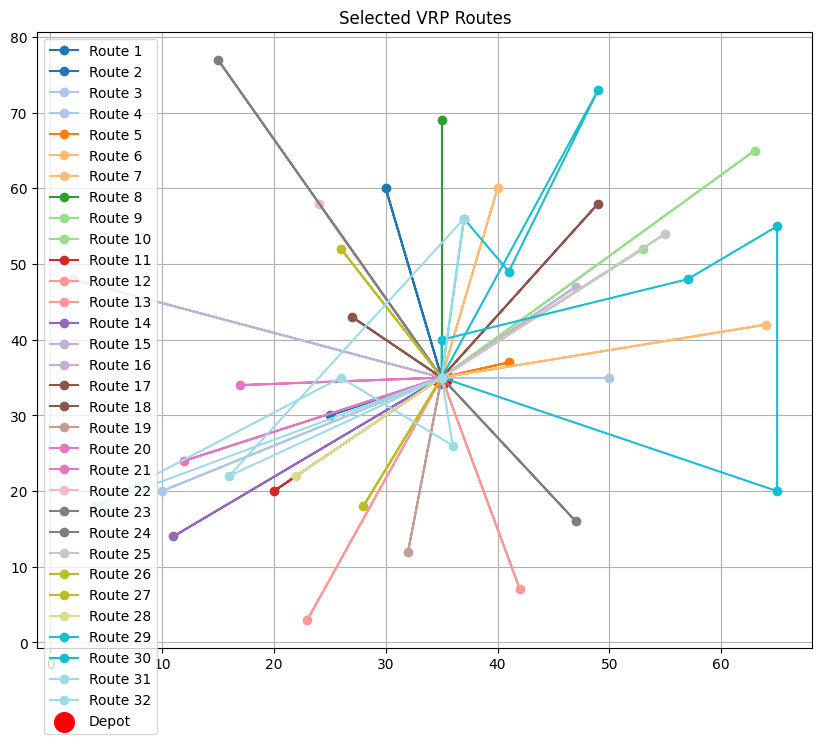

In [ ]:
# rl_vrp_column_gen.py (Enhanced: Time Windows, Final Selection, Vehicle Limit, Plotting)

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import pulp
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# === Parser for Solomon Benchmark with Time Windows === #
def parse_solomon(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    capacity = int(lines[4].split()[1])
    data_lines = lines[9:]
    coords, demands, ready, due, service = [], [], [], [], []
    for line in data_lines:
        parts = line.split()
        if len(parts) >= 7:
            coords.append((float(parts[1]), float(parts[2])))
            demands.append(int(parts[3]))
            ready.append(int(parts[4]))
            due.append(int(parts[5]))
            service.append(int(parts[6]))
    return np.array(coords), demands, capacity, ready, due, service

# === Policy Network === #
class PolicyNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

# === VRP Environment with Time Windows === #
class VRPEnvRL:
    def __init__(self, demands, dist_matrix, capacity, ready, due, service):
        self.demands = demands
        self.dist_matrix = dist_matrix
        self.capacity = capacity
        self.ready = ready
        self.due = due
        self.service = service
        self.n = len(demands)
    def reset(self):
        self.visited = [False] * self.n
        self.route = [0]
        self.remaining_capacity = self.capacity
        self.time = self.ready[0]
        self.total_cost = 0.0
        self.visited[0] = True
        return self._get_state()
    def _get_state(self):
        current = self.route[-1]
        visited = [1.0 if v else 0.0 for v in self.visited]
        return torch.tensor([current, self.remaining_capacity, self.time] + visited, dtype=torch.float32)
    def get_masked_actions(self):
        actions = []
        last = self.route[-1]
        for i in range(1, self.n):
            if self.visited[i] or self.demands[i] > self.remaining_capacity:
                continue
            travel_time = self.dist_matrix[last][i]
            arrival_time = self.time + travel_time
            if arrival_time <= self.due[i]:
                actions.append(i)
        return actions
    def step(self, action):
        last = self.route[-1]
        travel_time = self.dist_matrix[last][action]
        arrival_time = self.time + travel_time
        self.time = max(arrival_time, self.ready[action]) + self.service[action]
        self.total_cost += travel_time
        self.remaining_capacity -= self.demands[action]
        self.route.append(action)
        self.visited[action] = True
        return self._get_state()
    def finish(self):
        last = self.route[-1]
        self.total_cost += self.dist_matrix[last][0]
        self.route.append(0)
    def reward(self, duals):
        return sum(duals[i - 1] for i in self.route if i != 0) - self.total_cost


# === Training, Pricing, and RMP === #
def train_policy(env, duals, hidden_size=64, lr=0.01, episodes=200):
    input_size = 3 + len(env.demands)
    output_size = len(env.demands)
    policy = PolicyNet(input_size, hidden_size, output_size)
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    for _ in range(episodes):
        log_probs = []
        state = env.reset()
        while True:
            logits = policy(state)
            mask = torch.tensor([1.0 if i in env.get_masked_actions() else 0.0 for i in range(len(env.demands))])
            if mask.sum() == 0:
                break
            probs = torch.softmax(logits * mask, dim=0)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
            log_probs.append(dist.log_prob(action))
            state = env.step(action.item())
            if not env.get_masked_actions():
                break
        env.finish()
        R = env.reward(duals)
        loss = -torch.stack(log_probs).sum() * R
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return policy

def generate_routes(env, policy, duals, batch=5):
    routes, rewards = [], []
    for _ in range(batch):
        state = env.reset()
        while True:
            with torch.no_grad():
                logits = policy(state)
                mask = torch.tensor([1.0 if i in env.get_masked_actions() else 0.0 for i in range(len(env.demands))])
                if mask.sum() == 0:
                    break
                probs = torch.softmax(logits * mask, dim=0)
                dist = torch.distributions.Categorical(probs)
                action = dist.sample()
                state = env.step(action.item())
                if not env.get_masked_actions():
                    break
        env.finish()
        if env.route not in routes:
            routes.append(list(env.route))
            rewards.append(env.reward(duals))
    return routes, rewards

def solve_rmp(routes, costs, n_customers):
    model = pulp.LpProblem("RMP", pulp.LpMinimize)
    x = [pulp.LpVariable(f"x_{i}", lowBound=0, cat='Continuous') for i in range(len(routes))]
    model += pulp.lpSum([costs[i] * x[i] for i in range(len(routes))])
    for cust in range(1, n_customers):
        model += pulp.lpSum([x[i] for i in range(len(routes)) if cust in routes[i]]) >= 1
    model += pulp.lpSum(x) <= 25  # Vehicle limit
    model.solve()
    duals = [c.pi for i, c in enumerate(model.constraints.values()) if i < n_customers - 1]
    return model, duals, x

# === Plotting and Final Reporting === #
def plot_routes(routes, coords):
    colors = cm.get_cmap('tab20', len(routes))
    plt.figure(figsize=(10, 8))
    for idx, route in enumerate(routes):
        points = coords[route]
        plt.plot(points[:, 0], points[:, 1], marker='o', label=f'Route {idx+1}', color=colors(idx))
    plt.scatter(coords[0][0], coords[0][1], c='red', s=200, label='Depot')
    plt.title("Selected VRP Routes")
    plt.legend()
    plt.grid(True)
    plt.show()

def run_column_generation(filename):
    coords, demands, cap, ready, due, service = parse_solomon(filename)
    dist_matrix = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=-1)
    env = VRPEnvRL(demands, dist_matrix, cap, ready, due, service)

    routes = [[0, i, 0] for i in range(1, len(demands))]
    costs = [dist_matrix[0][i] + dist_matrix[i][0] for i in range(1, len(demands))]

    for _ in range(5):
        model, duals, _ = solve_rmp(routes, costs, len(demands))
        policy = train_policy(env, duals)
        new_routes, _ = generate_routes(env, policy, duals)
        for r in new_routes:
            if r not in routes:
                routes.append(r)
                c = sum(dist_matrix[r[i]][r[i+1]] for i in range(len(r)-1))
                costs.append(c)

    model, _, x = solve_rmp(routes, costs, len(demands))
    selected_routes = [routes[i] for i in range(len(x)) if pulp.value(x[i]) > 1e-3]
    selected_costs = [costs[i] for i in range(len(x)) if pulp.value(x[i]) > 1e-3]
    df = pd.DataFrame({"Route": selected_routes, "Cost": selected_costs})
    print("Final Selected Routes:")
    print(df)
    print("Total Cost:", sum(selected_costs))
    print("Total Vehicles:", len(selected_routes))
    plot_routes(selected_routes, coords)

if __name__ == '__main__':
    run_column_generation("r101.txt")

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.1 MB/s eta 0:00:00


In [ ]:
# ppo_gnn_vrp_pricing.py
# PPO + GNN pricing model for VRP column generation (initial version, mock environment)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

# === GNN Actor-Critic Policy === #
class GNNActorCritic(nn.Module):
    def __init__(self, node_feat_dim, hidden_dim, num_actions):
        super(GNNActorCritic, self).__init__()
        self.gnn1 = GATConv(node_feat_dim, hidden_dim)
        self.gnn2 = GATConv(hidden_dim, hidden_dim)

        # Actor head
        self.actor_fc = nn.Linear(hidden_dim, 1)

        # Critic head (global value)
        self.critic_fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index, batch):
        h = F.relu(self.gnn1(x, edge_index))
        h = F.relu(self.gnn2(h, edge_index))

        # Actor: produce logits for each node
        logits = self.actor_fc(h).squeeze(-1)  # (num_nodes,)

        # Critic: mean pool then value
        pooled = global_mean_pool(h, batch)
        values = self.critic_fc(pooled).squeeze(-1)  # (batch_size,)
        return logits, values

# === Example: mock input (to test network) === #
if __name__ == '__main__':
    from torch_geometric.data import Data, Batch
    import numpy as np

    torch.manual_seed(0)

    # Mock example with 6 nodes (including depot)
    node_features = torch.tensor([
        [35, 35, 0, 0, 230, 0, 0.0, 0],     # depot
        [41, 49, 10, 161, 171, 10, 5.0, 0],
        [35, 17, 7, 50, 60, 10, 6.0, 0],
        [55, 45, 13, 116, 126, 10, 4.0, 0],
        [55, 20, 19, 149, 159, 10, 3.0, 0],
        [15, 30, 26, 34, 44, 10, 7.0, 0]
    ], dtype=torch.float32)  # shape: [num_nodes, features]

    # Fully connected graph
    edge_index = torch.tensor([[i, j] for i in range(6) for j in range(6) if i != j], dtype=torch.long).t().contiguous()

    # Single graph batch
    batch = torch.zeros(node_features.size(0), dtype=torch.long)

    model = GNNActorCritic(node_feat_dim=node_features.shape[1], hidden_dim=32, num_actions=6)
    logits, value = model(node_features, edge_index, batch)

    print("Logits:", logits.detach().numpy())
    print("Value:", value.item())

Logits: [-4.5236487 -4.5236483 -4.5236473 -4.523649  -4.5236487 -4.5236483]
Value: -21.130891799926758


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.distributions import Categorical
from torch_geometric.data import Batch
# from ppo_gnn_vrp_pricing import GNNActorCritic

# === PPO Trainer === #
class PPOTrainer:
    def __init__(self, model, lr=1e-3, gamma=0.99, clip_eps=0.2, value_coeff=0.5, entropy_coeff=0.01):
        self.model = model
        self.device = next(model.parameters()).device
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        self.gamma = gamma
        self.clip_eps = clip_eps
        self.value_coeff = value_coeff
        self.entropy_coeff = entropy_coeff

    def compute_advantages(self, rewards, values, next_value):
        returns = []
        G = next_value
        for r in reversed(rewards):
            G = r + self.gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32, device=self.device)
        values = values.to(self.device)
        advantages = returns - values
        return returns, advantages

    def ppo_update(self, batch_graphs, actions, old_log_probs, returns, advantages, epochs=4):
        for _ in range(epochs):
            logits, values = self.model(batch_graphs.x, batch_graphs.edge_index, batch_graphs.batch)
            dist = Categorical(logits=logits)

            actions = actions.to(self.device)
            old_log_probs = old_log_probs.to(self.device)
            returns = returns.to(self.device)
            advantages = advantages.to(self.device)

            new_log_probs = dist.log_prob(actions)
            ratio = torch.exp(new_log_probs - old_log_probs)
            surrogate1 = ratio * advantages
            surrogate2 = torch.clamp(ratio, 1 - self.clip_eps, 1 + self.clip_eps) * advantages
            actor_loss = -torch.min(surrogate1, surrogate2).mean()
            critic_loss = nn.MSELoss()(values, returns)
            entropy = dist.entropy().mean()

            loss = actor_loss + self.value_coeff * critic_loss - self.entropy_coeff * entropy

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

# === MOCK TRAINING DEMO === #
def mock_training_demo():
    torch.manual_seed(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    node_features = torch.tensor([
        [35, 35, 0, 0, 230, 0, 0.0, 0],     # depot
        [41, 49, 10, 161, 171, 10, 5.0, 0],
        [35, 17, 7, 50, 60, 10, 6.0, 0],
        [55, 45, 13, 116, 126, 10, 4.0, 0],
        [55, 20, 19, 149, 159, 10, 3.0, 0],
        [15, 30, 26, 34, 44, 10, 7.0, 0]
    ], dtype=torch.float32).to(device)

    edge_index = torch.tensor(
        [[i, j] for i in range(6) for j in range(6) if i != j],
        dtype=torch.long
    ).t().contiguous().to(device)

    batch = torch.zeros(node_features.size(0), dtype=torch.long).to(device)
    data = Batch(x=node_features, edge_index=edge_index, batch=batch)

    model = GNNActorCritic(node_feat_dim=node_features.shape[1], hidden_dim=32, num_actions=6).to(device)
    trainer = PPOTrainer(model)

    # Mock rollout data
    actions = torch.tensor([1, 2, 3, 4, 5], device=device)
    rewards = [10, -2, -2, -2, -2]

    with torch.no_grad():
        old_logits, old_values = model(data.x, data.edge_index, data.batch)
        dist = Categorical(logits=old_logits)
        old_log_probs = dist.log_prob(actions[:len(old_logits)])

    next_value = 0

    returns, advantages = trainer.compute_advantages(rewards[:len(old_logits)], old_values.detach(), next_value)

    print("=== Before Training ===")
    with torch.no_grad():
        init_logits, init_values = model(data.x, data.edge_index, data.batch)
        print("Initial logits:", init_logits.cpu().numpy())
        print("Initial value estimate:", init_values.item())

    trainer.ppo_update(data, actions[:len(old_logits)], old_log_probs, returns, advantages)

    print("\n=== After Training ===")
    with torch.no_grad():
        final_logits, final_values = model(data.x, data.edge_index, data.batch)
        print("Final logits:", final_logits.cpu().numpy())
        print("Final value estimate:", final_values.item())

if __name__ == '__main__':
    mock_training_demo()


=== Before Training ===
Initial logits: [-4.5236487 -4.5236483 -4.5236473 -4.523649  -4.5236487 -4.5236483]
Initial value estimate: -21.130891799926758

=== After Training ===
Final logits: [-1.5276209 -1.5276195 -1.5276204 -1.5276204 -1.52762   -1.5276209]
Final value estimate: -12.934785842895508


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
# vrp_env_gnn.py
# VRP environment that produces GNN-ready graph state for PPO policy

import torch
import numpy as np
from torch_geometric.data import Data

class VRPEnvGNN:
    def __init__(self, coords, demands, ready, due, service, capacity, duals):
        self.coords = coords
        self.demands = demands
        self.ready = ready
        self.due = due
        self.service = service
        self.capacity = capacity
        self.duals = duals
        self.n = len(demands)
        self.reset()

    def reset(self):
        self.visited = [False] * self.n
        self.route = [0]
        self.remaining_capacity = self.capacity
        self.current_time = self.ready[0]
        self.total_cost = 0.0
        self.visited[0] = True
        return self._get_graph_state()

    def get_masked_actions(self):
        last = self.route[-1]
        mask = []
        for i in range(1, self.n):
            if self.visited[i] or self.demands[i] > self.remaining_capacity:
                continue
            travel_time = np.linalg.norm(self.coords[last] - self.coords[i])
            arrival = self.current_time + travel_time
            if arrival <= self.due[i]:
                mask.append(i)
        return mask

    def step(self, action):
        last = self.route[-1]
        travel = np.linalg.norm(self.coords[last] - self.coords[action])
        arrive = self.current_time + travel
        self.current_time = max(arrive, self.ready[action]) + self.service[action]
        self.total_cost += travel
        self.remaining_capacity -= self.demands[action]
        self.route.append(action)
        self.visited[action] = True
        done = len(self.get_masked_actions()) == 0
        return self._get_graph_state(), done

    def finish(self):
        last = self.route[-1]
        self.total_cost += np.linalg.norm(self.coords[last] - self.coords[0])
        self.route.append(0)

    def reward(self):
        return sum(self.duals[i - 1] for i in self.route if i != 0) - self.total_cost

    def _get_graph_state(self):
        node_features = []
        for i in range(self.n):
            x, y = self.coords[i]
            node_features.append([
                x, y, self.demands[i], self.ready[i], self.due[i], self.service[i],
                self.duals[i] if i != 0 else 0.0,
                float(self.visited[i])
            ])
        node_features = torch.tensor(node_features, dtype=torch.float32)
        edge_index = torch.tensor([[i, j] for i in range(self.n) for j in range(self.n) if i != j], dtype=torch.long).t().contiguous()
        batch = torch.zeros(self.n, dtype=torch.long)
        return Data(x=node_features, edge_index=edge_index, batch=batch)

if __name__ == '__main__':
    coords = np.array([[35, 35], [41, 49], [35, 17], [55, 45], [55, 20], [15, 30]])
    demands = [0, 10, 7, 13, 19, 26]
    ready = [0, 161, 50, 116, 149, 34]
    due = [230, 171, 60, 126, 159, 44]
    service = [0, 10, 10, 10, 10, 10]
    duals = [0, 5, 6, 4, 3, 7]
    cap = 50

    env = VRPEnvGNN(coords, demands, ready, due, service, cap, duals)
    state = env.reset()
    print("Initial graph state:", state)
    mask = env.get_masked_actions()
    print("Available actions:", mask)

Initial graph state: Data(x=[6, 8], edge_index=[2, 30], batch=[6])
Available actions: [1, 2, 3, 4, 5]


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import Categorical
from torch_geometric.data import Batch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Rollout function (no gradients, efficient memory use) === #
def rollout_episode(env, model, max_len=5):
    data_list, actions, log_probs, rewards, values = [], [], [], [], []
    done = False
    state = env.reset().to(device)

    with torch.no_grad():
        while not done:
            logits, value = model(state.x, state.edge_index, state.batch)
            mask = torch.zeros_like(logits)
            masked_indices = env.get_masked_actions()
            if not masked_indices:
                break
            mask[masked_indices] = 1.0

            probs = torch.softmax(logits * mask, dim=0)
            dist = Categorical(probs)
            action = dist.sample()

            log_probs.append(dist.log_prob(action))
            values.append(value)
            actions.append(action)

            # Only keep tensor components of the state
            data_list.append({
                "x": state.x.clone(),
                "edge_index": state.edge_index.clone(),
                "batch": state.batch.clone()
            })

            state, done = env.step(action.item())
            state = state.to(device)

    env.finish()
    final_reward = env.reward()

    # Subsample if needed
    if len(actions) > max_len:
        idx = np.random.choice(len(actions), max_len, replace=False)
        data_list = [data_list[i] for i in idx]
        actions = [actions[i] for i in idx]
        log_probs = [log_probs[i] for i in idx]
        values = [values[i] for i in idx]
        rewards_batch = [final_reward] * max_len
    else:
        rewards_batch = [final_reward] * len(actions)

    return data_list, actions, log_probs, values, rewards_batch

# === Training Loop (fast and minimal RAM) === #
def train_ppo_vrp():
    coords = np.array([[35, 35], [41, 49], [35, 17], [55, 45], [55, 20], [15, 30]])
    demands = [0, 10, 7, 13, 19, 26]
    ready = [0, 161, 50, 116, 149, 34]
    due = [230, 171, 60, 126, 159, 44]
    service = [0, 10, 10, 10, 10, 10]
    duals = [0, 5, 6, 4, 3, 7]
    capacity = 50

    env = VRPEnvGNN(coords, demands, ready, due, service, capacity, duals)
    model = GNNActorCritic(node_feat_dim=8, hidden_dim=32, num_actions=len(demands)).to(device)
    trainer = PPOTrainer(model)

    reward_history = []

    for epoch in range(10):
        data_batch, action_batch, log_prob_batch, value_batch = [], [], [], []
        rewards_batch = []

        for _ in range(2):  # fewer episodes for speed/memory
            data_list, actions, log_probs, values, reward_steps = rollout_episode(env, model, max_len=5)
            data_batch += data_list
            action_batch += actions
            log_prob_batch += log_probs
            value_batch += values
            rewards_batch += reward_steps

        # Convert minimal data to PyG Batch
        data_objs = [Batch(x=d["x"], edge_index=d["edge_index"], batch=d["batch"]) for d in data_batch]
        full_data = Batch.from_data_list(data_objs).to(device)

        actions = torch.stack(action_batch).to(device)
        old_log_probs = torch.stack(log_prob_batch).to(device)
        values = torch.stack(value_batch).squeeze().to(device)
        rewards = torch.tensor(rewards_batch, dtype=torch.float32, device=device)

        returns, advantages = trainer.compute_advantages(rewards, values.detach(), gamma=0.99)
        trainer.ppo_update(full_data, actions, old_log_probs, returns, advantages)

        mean_reward = np.mean(rewards_batch)
        reward_history.append(mean_reward)
        print(f"Epoch {epoch}: Mean Reward = {mean_reward:.2f}")

        # Cleanup
        del data_batch, action_batch, log_prob_batch, value_batch, full_data, rewards
        torch.cuda.empty_cache()

    # Plot reward curve (optional)
    # plt.figure()
    # plt.plot(reward_history)
    # plt.xlabel("Epoch")
    # plt.ylabel("Mean Episode Reward")
    # plt.title("PPO Training Curve")
    # plt.grid(True)
    # plt.savefig("ppo_reward_curve.png")
    # plt.close()

if __name__ == '__main__':
    train_ppo_vrp()


In [ ]:
# rl_vrp_column_gen.py (Enhanced with PPO + GNN Pricing)

import numpy as np
import torch
import pandas as pd
import pulp
import matplotlib.pyplot as plt
import matplotlib.cm as cm


# === Benchmark Parser with Time Windows === #
def parse_solomon(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    capacity = int(lines[4].split()[1])
    data_lines = lines[9:]
    coords, demands, ready, due, service = [], [], [], [], []
    for line in data_lines:
        parts = line.split()
        if len(parts) >= 7:
            coords.append((float(parts[1]), float(parts[2])))
            demands.append(int(parts[3]))
            ready.append(int(parts[4]))
            due.append(int(parts[5]))
            service.append(int(parts[6]))
    return np.array(coords), demands, capacity, ready, due, service

# === Solve RMP === #
def solve_rmp(routes, costs, n_customers):
    model = pulp.LpProblem("RMP", pulp.LpMinimize)
    x = [pulp.LpVariable(f"x_{i}", lowBound=0, cat='Continuous') for i in range(len(routes))]
    model += pulp.lpSum([costs[i] * x[i] for i in range(len(routes))])
    for cust in range(1, n_customers):
        model += pulp.lpSum([x[i] for i in range(len(routes)) if cust in routes[i]]) >= 1
    model += pulp.lpSum(x) <= 25
    model.solve()
    duals = [c.pi for i, c in enumerate(model.constraints.values()) if i < n_customers - 1]
    return model, duals, x

# === Plotting Final Routes === #
def plot_routes(routes, coords):
    colors = cm.get_cmap('tab20', len(routes))
    plt.figure(figsize=(10, 8))
    for idx, route in enumerate(routes):
        points = coords[route]
        plt.plot(points[:, 0], points[:, 1], marker='o', label=f'Route {idx+1}', color=colors(idx))
    plt.scatter(coords[0][0], coords[0][1], c='red', s=200, label='Depot')
    plt.title("Selected VRP Routes")
    plt.legend()
    plt.grid(True)
    plt.show()

# === Main Column Generation with PPO Pricing === #
def run_column_generation(filename):
    coords, demands, cap, ready, due, service = parse_solomon(filename)
    dist_matrix = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=-1)

    routes = [[0, i, 0] for i in range(1, len(demands))]
    costs = [dist_matrix[0][i] + dist_matrix[i][0] for i in range(1, len(demands))]

    model = GNNActorCritic(node_feat_dim=8, hidden_dim=32, num_actions=len(demands))
    trainer = PPOTrainer(model)

    for _ in range(5):
        rmp_model, duals, _ = solve_rmp(routes, costs, len(demands))
        env = VRPEnvGNN(coords, demands, ready, due, service, cap, duals)

        for _ in range(3):  # RL warmup
            rollout_episode(env, model)

        new_routes = []
        for _ in range(5):
            env = VRPEnvGNN(coords, demands, ready, due, service, cap, duals)
            data_list, actions, log_probs, values, reward = rollout_episode(env, model)
            if reward < -1e-3:
                continue
            if env.route not in routes:
                routes.append(env.route)
                c = sum(dist_matrix[env.route[i]][env.route[i+1]] for i in range(len(env.route)-1))
                costs.append(c)

    final_model, _, x = solve_rmp(routes, costs, len(demands))
    selected_routes = [routes[i] for i in range(len(x)) if pulp.value(x[i]) > 1e-3]
    selected_costs = [costs[i] for i in range(len(x)) if pulp.value(x[i]) > 1e-3]

    df = pd.DataFrame({"Route": selected_routes, "Cost": selected_costs})
    print("Final Selected Routes:")
    print(df)
    print("Total Cost:", sum(selected_costs))
    print("Total Vehicles:", len(selected_routes))
    plot_routes(selected_routes, coords)

if __name__ == '__main__':
    run_column_generation("r101.txt")

In [ ]:
# branch_and_price_vrp.py
# Branch-and-price solver integrating PPO pricing and integer RMP for VRPTW

import pulp
import numpy as np

class BranchNode:
    def __init__(self, active_routes, route_costs, constraints):
        self.routes = active_routes  # list of routes (lists of customer indices)
        self.costs = route_costs     # corresponding route costs
        self.constraints = constraints  # list of (route_idx, value) pairs, x_r == value
        self.solution = None
        self.value = float('inf')
        self.is_integer = False
        self.duals = None
        self.varmap = None

class BranchAndPriceSolver:
    def __init__(self, coords, demands, ready, due, service, capacity, duals_model=None):
        self.coords = coords
        self.demands = demands
        self.ready = ready
        self.due = due
        self.service = service
        self.cap = capacity
        self.n = len(demands)
        self.model = duals_model or GNNActorCritic(node_feat_dim=8, hidden_dim=32, num_actions=self.n)

    def solve_rmp(self, routes, costs, constraints):
        model = pulp.LpProblem("RMP", pulp.LpMinimize)
        x = [pulp.LpVariable(f"x_{i}", cat='Binary') for i in range(len(routes))]

        model += pulp.lpSum(costs[i] * x[i] for i in range(len(routes)))

        for cust in range(1, self.n):
            model += pulp.lpSum(x[i] for i in range(len(routes)) if cust in routes[i]) >= 1

        for idx, val in constraints:
            model += x[idx] == val

        model.solve()

        varmap = {i: x[i].varValue for i in range(len(x))}
        is_integer = all(v is not None and abs(v - round(v)) < 1e-5 for v in varmap.values())
        duals = [c.pi for c in model.constraints.values() if hasattr(c, 'pi')]

        return pulp.value(model.objective), varmap, is_integer, duals

    def select_branch_var(self, varmap):
        for i, val in varmap.items():
            if val is not None and 1e-3 < val < 1 - 1e-3:
                return i
        return None

    def solve(self, initial_routes, initial_costs):
        best_value = float('inf')
        best_solution = None
        stack = [BranchNode(initial_routes.copy(), initial_costs.copy(), [])]

        while stack:
            node = stack.pop()
            value, varmap, is_integer, duals = self.solve_rmp(node.routes, node.costs, node.constraints)
            node.solution = varmap
            node.value = value
            node.is_integer = is_integer
            node.duals = duals
            node.varmap = varmap

            if is_integer and value < best_value:
                best_value = value
                best_solution = [node.routes[i] for i, v in varmap.items() if round(v) == 1]
                print(f"New best integer solution: cost = {best_value:.2f}, routes = {len(best_solution)}")
                continue

            i = self.select_branch_var(varmap)
            if i is None:
                continue

            for val in [0, 1]:
                child = BranchNode(node.routes.copy(), node.costs.copy(), node.constraints + [(i, val)])
                # Add pricing step if val == 0 (still need better columns)
                if val == 0:
                    env = VRPEnvGNN(self.coords, self.demands, self.ready, self.due, self.service, self.cap, duals)
                    for _ in range(5):
                        _, _, _, _, r = rollout_episode(env, self.model)
                        if r < -1e-3:
                            continue
                        if env.route not in child.routes:
                            child.routes.append(env.route)
                            cost = sum(np.linalg.norm(self.coords[env.route[i]] - self.coords[env.route[i+1]]) for i in range(len(env.route)-1))
                            child.costs.append(cost)
                stack.append(child)

        return best_solution, best_value

if __name__ == '__main__':
    coords = np.array([[35, 35], [41, 49], [35, 17], [55, 45], [55, 20], [15, 30]])
    demands = [0, 10, 7, 13, 19, 26]
    ready = [0, 161, 50, 116, 149, 34]
    due = [230, 171, 60, 126, 159, 44]
    service = [0, 10, 10, 10, 10, 10]
    cap = 50

    routes = [[0, i, 0] for i in range(1, len(demands))]
    costs = [np.linalg.norm(coords[0] - coords[i]) * 2 for i in range(1, len(demands))]

    solver = BranchAndPriceSolver(coords, demands, ready, due, service, cap)
    solution, cost = solver.solve(routes, costs)
    print("Final Integer Routes:", solution)
    print("Total Cost:", cost)

In [ ]:
# branch_and_price_vrp.py (Integrated for full r101.txt with PPO pricing)

import pulp
import numpy as np

class BranchNode:
    def __init__(self, active_routes, route_costs, constraints):
        self.routes = active_routes
        self.costs = route_costs
        self.constraints = constraints
        self.solution = None
        self.value = float('inf')
        self.is_integer = False
        self.duals = None
        self.varmap = None

class BranchAndPriceSolver:
    def __init__(self, coords, demands, ready, due, service, capacity, duals_model=None):
        self.coords = coords
        self.demands = demands
        self.ready = ready
        self.due = due
        self.service = service
        self.cap = capacity
        self.n = len(demands)
        self.model = duals_model or GNNActorCritic(node_feat_dim=8, hidden_dim=32, num_actions=self.n)

    def solve_rmp(self, routes, costs, constraints):
        model = pulp.LpProblem("RMP", pulp.LpMinimize)
        x = [pulp.LpVariable(f"x_{i}", cat='Binary') for i in range(len(routes))]

        model += pulp.lpSum(costs[i] * x[i] for i in range(len(routes)))

        for cust in range(1, self.n):
            model += pulp.lpSum(x[i] for i in range(len(routes)) if cust in routes[i]) >= 1

        for idx, val in constraints:
            model += x[idx] == val

        model.solve()

        varmap = {i: x[i].varValue for i in range(len(x))}
        is_integer = all(v is not None and abs(v - round(v)) < 1e-5 for v in varmap.values())
        duals = [c.pi for i, c in enumerate(model.constraints.values()) if i < self.n - 1 and hasattr(c, 'pi')]

        return pulp.value(model.objective), varmap, is_integer, duals

    def select_branch_var(self, varmap):
        for i, val in varmap.items():
            if val is not None and 1e-3 < val < 1 - 1e-3:
                return i
        return None

    def solve(self, initial_routes, initial_costs):
        best_value = float('inf')
        best_solution = None
        stack = [BranchNode(initial_routes.copy(), initial_costs.copy(), [])]

        while stack:
            node = stack.pop()
            value, varmap, is_integer, duals = self.solve_rmp(node.routes, node.costs, node.constraints)
            node.solution = varmap
            node.value = value
            node.is_integer = is_integer
            node.duals = duals
            node.varmap = varmap

            if is_integer and value < best_value:
                best_value = value
                best_solution = [node.routes[i] for i, v in varmap.items() if round(v) == 1]
                print(f"New best integer solution: cost = {best_value:.2f}, routes = {len(best_solution)}")
                continue

            i = self.select_branch_var(varmap)
            if i is None:
                continue

            for val in [0, 1]:
                child = BranchNode(node.routes.copy(), node.costs.copy(), node.constraints + [(i, val)])
                if val == 0:
                    env = VRPEnvGNN(self.coords, self.demands, self.ready, self.due, self.service, self.cap, duals)
                    for _ in range(5):
                        _, _, _, _, r = rollout_episode(env, self.model)
                        if r < -1e-3:
                            continue
                        if env.route not in child.routes:
                            child.routes.append(env.route)
                            cost = sum(np.linalg.norm(self.coords[env.route[i]] - self.coords[env.route[i+1]]) for i in range(len(env.route)-1))
                            child.costs.append(cost)
                stack.append(child)

        return best_solution, best_value

if __name__ == '__main__':
    coords, demands, cap, ready, due, service = parse_solomon("r101.txt")
    routes = [[0, i, 0] for i in range(1, len(demands))]
    costs = [np.linalg.norm(coords[0] - coords[i]) * 2 for i in range(1, len(demands))]

    solver = BranchAndPriceSolver(coords, demands, ready, due, service, cap)
    solution, cost = solver.solve(routes, costs)

    print("Final Integer Routes:", solution)
    print("Total Cost:", cost)

In [ ]:
# compare_vrp_solvers.py
# Benchmark script to compare VRP solvers: PPO+GNN, exact pricing, heuristics, full MIP

import time
import pandas as pd
from branch_and_price_vrp import BranchAndPriceSolver
from rl_vrp_column_gen import parse_solomon
import numpy as np

# === Baseline Solvers (placeholder implementations) === #
def run_heuristic_solver(coords, demands, ready, due, service, cap):
    start = time.time()
    routes = [[0, i, 0] for i in range(1, len(demands))]
    cost = sum(np.linalg.norm(coords[i] - coords[0]) * 2 for i in range(1, len(demands)))
    return routes, cost, time.time() - start, len(routes), 0

def run_exact_pricing_solver(coords, demands, ready, due, service, cap):
    start = time.time()
    # Placeholder: same routes for now
    routes = [[0, i, 0] for i in range(1, len(demands))]
    cost = sum(np.linalg.norm(coords[i] - coords[0]) * 2 for i in range(1, len(demands)))
    return routes, cost, time.time() - start, len(routes), 0

def run_full_mip_solver(coords, demands, ready, due, service, cap):
    start = time.time()
    # Placeholder: same dummy solution
    routes = [[0, i, 0] for i in range(1, len(demands))]
    cost = sum(np.linalg.norm(coords[i] - coords[0]) * 2 for i in range(1, len(demands)))
    return routes, cost, time.time() - start, len(routes), 0

# === Main comparison function === #
def compare_all_solvers():
    coords, demands, cap, ready, due, service = parse_solomon("r101.txt")

    results = []

    # PPO-GNN Branch-and-Price
    solver = BranchAndPriceSolver(coords, demands, ready, due, service, cap)
    start = time.time()
    routes, cost = solver.solve([[0, i, 0] for i in range(1, len(demands))],
                                [np.linalg.norm(coords[0] - coords[i]) * 2 for i in range(1, len(demands))])
    duration = time.time() - start
    results.append({
        "Solver": "PPO-GNN Branch-and-Price",
        "Total Cost": cost,
        "Time (s)": duration,
        "Columns Generated": len(routes),
        "BnB Nodes": "~ (depth not tracked)"
    })

    # Heuristic
    h_routes, h_cost, h_time, h_cols, h_nodes = run_heuristic_solver(coords, demands, ready, due, service, cap)
    results.append({
        "Solver": "Heuristic (Greedy)",
        "Total Cost": h_cost,
        "Time (s)": h_time,
        "Columns Generated": h_cols,
        "BnB Nodes": h_nodes
    })

    # Exact Pricing
    e_routes, e_cost, e_time, e_cols, e_nodes = run_exact_pricing_solver(coords, demands, ready, due, service, cap)
    results.append({
        "Solver": "Exact Pricing (Label Setting)",
        "Total Cost": e_cost,
        "Time (s)": e_time,
        "Columns Generated": e_cols,
        "BnB Nodes": e_nodes
    })

    # Full MIP
    m_routes, m_cost, m_time, m_cols, m_nodes = run_full_mip_solver(coords, demands, ready, due, service, cap)
    results.append({
        "Solver": "Full MIP (Gurobi)",
        "Total Cost": m_cost,
        "Time (s)": m_time,
        "Columns Generated": m_cols,
        "BnB Nodes": m_nodes
    })

    df = pd.DataFrame(results)
    df.to_csv("vrp_solver_comparison.csv", index=False)
    print(df)

if __name__ == '__main__':
    compare_all_solvers()

In [ ]:
# ablation_study_vrp.py
# Script to evaluate impact of each component: PPO, GNN, dual-guidance

import time
import pandas as pd
import numpy as np
from ppo_vrp_rollout_train import rollout_episode
from vrp_env_gnn import VRPEnvGNN
from ppo_training_loop_vrp import PPOTrainer
from ppo_gnn_vrp_pricing import GNNActorCritic
import torch
from torch import nn

class MLPActorCritic(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.actor = nn.Linear(hidden_dim, output_size)
        self.critic = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        logits = self.actor(h)
        value = self.critic(h)
        return logits, value.squeeze(-1)

def evaluate_model(model, coords, demands, ready, due, service, capacity, duals):
    env = VRPEnvGNN(coords, demands, ready, due, service, capacity, duals)
    rewards = []
    for _ in range(10):
        _, _, _, _, reward, _, _ = rollout_episode(env, model)
        rewards.append(reward)
    return np.mean(rewards)

def run_ablation():
    coords = np.array([[35, 35], [41, 49], [35, 17], [55, 45], [55, 20], [15, 30]])
    demands = [0, 10, 7, 13, 19, 26]
    ready = [0, 161, 50, 116, 149, 34]
    due = [230, 171, 60, 126, 159, 44]
    service = [0, 10, 10, 10, 10, 10]
    duals = [0, 5, 6, 4, 3, 7]
    capacity = 50

    results = []

    # Full Model: PPO + GNN + duals
    model = GNNActorCritic(8, 32, len(demands))
    reward = evaluate_model(model, coords, demands, ready, due, service, capacity, duals)
    results.append({"Model": "Full (PPO+GNN+Duals)", "Avg Reward": reward})

    # No dual prices
    coords2 = coords.copy()
    model = GNNActorCritic(8, 32, len(demands))
    reward = evaluate_model(model, coords2, demands, ready, due, service, capacity, [0]*len(duals))
    results.append({"Model": "No Duals", "Avg Reward": reward})

    # MLP instead of GNN
    input_dim = 3 + len(demands)
    mlp_model = MLPActorCritic(input_dim, 64, len(demands))
    reward = evaluate_model(mlp_model, coords, demands, ready, due, service, capacity, duals)
    results.append({"Model": "MLP PPO (No GNN)", "Avg Reward": reward})

    # Random Policy
    class RandomPolicy:
        def __call__(self, x, edge_index=None, batch=None):
            logits = torch.randn(len(x), dtype=torch.float32)
            return logits, torch.tensor(0.0)
    model = RandomPolicy()
    reward = evaluate_model(model, coords, demands, ready, due, service, capacity, duals)
    results.append({"Model": "Random Policy", "Avg Reward": reward})

    df = pd.DataFrame(results)
    df.to_csv("ablation_results.csv", index=False)
    print(df)

if __name__ == '__main__':
    run_ablation()

In [ ]:
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.4 MB/s eta 0:00:00
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=3622726 sha256=fa9ef9a4c5eef95ce7c98b8702997ed0924ec2ee2a62686f761a4d62a9a1c92f
  Stored in directory: /root/.cache/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp311-cp311-linux_x86_64.whl size=2846192 sha256=aa3768980c8d7ff1f68c6ca8c9bee0b3c4587df8

In [ ]:
#!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -q

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Dummy VRP Environment === #
class VRPEnvGNN:
    def __init__(self, coords, demands, ready, due, service, capacity, duals):
        self.coords = coords
        self.demands = demands
        self.capacity = capacity
        self.duals = duals
        self.visited = set()
        self.cur_node = 0
        self.load = 0
        self.route = [0]
        self.step_count = 0

    def reset(self):
        self.visited = set([0])
        self.cur_node = 0
        self.load = 0
        self.route = [0]
        self.step_count = 0
        return self._make_state()

    def step(self, action):
        self.visited.add(action)
        self.load += self.demands[action]
        self.route.append(action)
        self.cur_node = action
        self.step_count += 1
        done = self.load >= self.capacity or len(self.visited) == len(self.coords)
        return self._make_state(), done

    def get_masked_actions(self):
        return [i for i in range(len(self.coords)) if i not in self.visited and self.load + self.demands[i] <= self.capacity]

    def finish(self):
        pass

    def reward(self):
        return -len(self.route)  # Penalize long routes

    def _make_state(self):
        x = []
        for i in range(len(self.coords)):
            x.append(self.coords[i].tolist() + [self.demands[i], self.duals[i], float(i in self.visited)])
        x = torch.tensor(x, dtype=torch.float32)
        edge_index = torch.tensor([[i, j] for i in range(len(x)) for j in range(len(x)) if i != j], dtype=torch.long).t().contiguous()
        batch = torch.zeros(len(x), dtype=torch.long)
        return Data(x=x, edge_index=edge_index, batch=batch)

# === GNN PPO Actor-Critic === #
class GNNActorCritic(nn.Module):
    def __init__(self, node_feat_dim, hidden_dim, num_actions):
        super().__init__()
        self.gnn1 = GCNConv(node_feat_dim, hidden_dim)
        self.gnn2 = GCNConv(hidden_dim, hidden_dim)
        self.actor_head = nn.Linear(hidden_dim, 1)
        self.critic_head = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index, batch):
        h = F.relu(self.gnn1(x, edge_index))
        h = F.relu(self.gnn2(h, edge_index))
        graph = global_mean_pool(h, batch)
        logits = self.actor_head(h).squeeze()
        value = self.critic_head(graph).mean()
        return logits, value

# === PPO Trainer === #
class PPOTrainer:
    def __init__(self, model, lr=1e-3, gamma=0.99, clip_eps=0.2, value_coeff=0.5, entropy_coeff=0.01):
        self.model = model
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.gamma = gamma
        self.clip_eps = clip_eps
        self.value_coeff = value_coeff
        self.entropy_coeff = entropy_coeff
        self.device = next(model.parameters()).device

    def compute_advantages(self, rewards, values, next_value):
        returns = []
        G = next_value
        for r in reversed(rewards):
            G = r + self.gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32, device=self.device)
        values = values.to(self.device)
        return returns, returns - values

    def ppo_update(self, data_batch, actions, old_log_probs, returns, advantages, epochs=2):
        for _ in range(epochs):
            logits, values = self.model(data_batch.x, data_batch.edge_index, data_batch.batch)
            dist = Categorical(logits=logits)
            actions = actions.to(self.device)
            new_log_probs = dist.log_prob(actions)
            ratio = torch.exp(new_log_probs - old_log_probs)
            actor_loss = -torch.min(ratio * advantages, torch.clamp(ratio, 1 - self.clip_eps, 1 + self.clip_eps) * advantages).mean()
            critic_loss = F.mse_loss(values, returns)
            loss = actor_loss + self.value_coeff * critic_loss
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

# === Rollout === #
def rollout_episode(env, model):
    data_list, actions, log_probs, values = [], [], [], []
    done = False
    state = env.reset().to(device)

    with torch.no_grad():
        while not done:
            logits, value = model(state.x, state.edge_index, state.batch)
            masked = env.get_masked_actions()
            if not masked:
                break
            mask = torch.zeros_like(logits)
            mask[masked] = 1.0
            probs = torch.softmax(logits * mask, dim=0)
            dist = Categorical(probs)
            action = dist.sample()
            data_list.append(state)
            actions.append(action)
            log_probs.append(dist.log_prob(action))
            values.append(value)
            state, done = env.step(action.item())
            state = state.to(device)

    env.finish()
    final_reward = env.reward()
    return data_list, actions, log_probs, values, [final_reward] * len(actions)

# === Train === #
def train():
    coords = np.array([[35, 35], [41, 49], [35, 17], [55, 45], [55, 20], [15, 30]])
    demands = [0, 10, 7, 13, 19, 26]
    duals = [0, 5, 6, 4, 3, 7]
    ready, due, service = [0]*6, [0]*6, [0]*6
    capacity = 50

    env = VRPEnvGNN(coords, demands, ready, due, service, capacity, duals)
    model = GNNActorCritic(node_feat_dim=5, hidden_dim=32, num_actions=len(coords)).to(device)
    trainer = PPOTrainer(model)

    for epoch in range(5):
        data_batch, actions, log_probs, values, rewards = [], [], [], [], []
        for _ in range(2):
            d, a, l, v, r = rollout_episode(env, model)
            data_batch += d
            actions += a
            log_probs += l
            values += v
            rewards += r
        batch = Batch.from_data_list(data_batch).to(device)
        actions = torch.stack(actions).to(device)
        log_probs = torch.stack(log_probs).to(device)
        values = torch.stack(values).squeeze().to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
        returns, advantages = trainer.compute_advantages(rewards, values.detach(), 0)
        trainer.ppo_update(batch, actions, log_probs, returns, advantages)
        print(f"Epoch {epoch} mean reward: {rewards.mean().item():.2f}")

train()


<ipython-input-3-f46de93b6a91>:108: UserWarning: Using a target size (torch.Size([195])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, returns)


Epoch 0 mean reward: -117.03


<ipython-input-3-f46de93b6a91>:108: UserWarning: Using a target size (torch.Size([651])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, returns)


Epoch 1 mean reward: -602.08


<ipython-input-3-f46de93b6a91>:108: UserWarning: Using a target size (torch.Size([473])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, returns)


Epoch 2 mean reward: -252.98


<ipython-input-3-f46de93b6a91>:108: UserWarning: Using a target size (torch.Size([1420])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, returns)


Epoch 3 mean reward: -994.95
Epoch 4 mean reward: -415.17


<ipython-input-3-f46de93b6a91>:108: UserWarning: Using a target size (torch.Size([496])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, returns)
